<h1><b font size = "50px" font-color: black>Spam Detection Filter<b></h1>

By using the dataset from https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection where they collected spam and ham messages of over 5,000+ SMS messages, we can use basic machine learning from these data to estimate if a message is spam or ham

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint

In [2]:
class NaiveBayes:

    def __init__(self, random, prior_spam):
        self.random = random
        self.prior_spam = prior_spam

    def load_data(self):
        df = pd.read_csv("./spam.csv", encoding='latin-1')
        return df

    def clean_data(self, df):
        clean = df.drop(['Unnamed: 2'], axis=1)
        clean = clean.drop(['Unnamed: 3'], axis = 1)
        clean = clean.drop(['Unnamed: 4'], axis = 1)
        clean.rename(columns = {'v1' : 'Category', 'v2' : 'Message'}, inplace=True)
        clean["Message"] = clean["Message"].str.replace('[^a-zA-Z]',' ', regex = True)
        clean["Message"] = clean["Message"].str.lower()
        return clean
    
    def split_data(self, clean):
        train_data, test_data = train_test_split(clean, test_size=0.25, random_state = self.random)
        return train_data, test_data
    
    def get_spam_ham_counts(self, train_data):
        spam_dict = {}
        ham_dict = {}
        for row in train_data.itertuples():
            for word in row.Message:
                if row.Category == "ham":
                    if word in ham_dict:
                        ham_dict[str(word)] += 1
                    else:
                        ham_dict[str(word)] = 1
                else:
                    if word in spam_dict:
                        spam_dict[word] += 1
                    else:
                        spam_dict[word] = 1
        return spam_dict, ham_dict
    
    def check_if_spam(self, message, spam_dict, ham_dict, total_spam, total_ham):
        #prior_spam = total_spam / (total_ham + total_spam)
        prior_spam = self.prior_spam
        prior_ham = 1 - prior_spam
        log_prob_spam = math.log(prior_spam)
        log_prob_ham = math.log(prior_ham)
        for word in message.split():
            if word in spam_dict:
                log_prob_spam += math.log(spam_dict[word])
            if word in ham_dict:
                log_prob_ham += math.log(ham_dict[word])
        if log_prob_spam > log_prob_ham:
            return "spam"
        else:
            return "ham"
    def run_model_against_test_data(self, test_data, spam_dict, ham_dict, total_spam, total_ham):
        # Order test result_actual value
        ham_ham = 0
        ham_spam = 0
        spam_spam = 0
        spam_ham = 0

        for row in test_data.itertuples():
            spam_or_ham = self.check_if_spam(row.Message, spam_dict, ham_dict, total_spam, total_ham)
            if spam_or_ham == row.Category and spam_or_ham == "ham":
                ham_ham += 1
            elif spam_or_ham == row.Category and spam_or_ham == "spam":
                spam_spam += 1
            elif spam_or_ham != row.Category and spam_or_ham == "ham":
                ham_spam += 1
            elif spam_or_ham != row.Category and spam_or_ham == "spam":
                spam_ham += 1
            else:
                print("Error")
        return ham_ham, ham_spam, spam_spam, spam_ham

    def display_results(self, spam_spam, ham_ham, spam_ham, ham_spam):
        #print("Spam matched by spam = " + str(spam_spam))
        #print("Ham matched by ham = " + str(ham_ham))
        #print("Ham matched by spam = " + str(spam_ham))
        #print("Spam matched by ham = "+str(ham_spam))
        accuracy = (spam_spam + ham_ham)/(spam_spam + ham_ham + spam_ham + ham_spam)
        accuracy *= 100
        accuracy = round(accuracy, 2)
        #print("Accuracy: "+str(accuracy)+"%")
        return accuracy

    def main(self):
        df = self.load_data()
        clean = self.clean_data(df)
        train_data, test_data = self.split_data(clean)
        train_data["Message"] = train_data["Message"].str.split()
        spam_dict, ham_dict = self.get_spam_ham_counts(train_data)
        total_spam = sum(spam_dict.values())
        total_ham = sum(ham_dict.values())
        ham_ham, ham_spam, spam_spam, spam_ham = self.run_model_against_test_data(test_data, spam_dict, ham_dict, total_spam, total_ham)
        accuracy = self.display_results(spam_spam, ham_ham, spam_ham, ham_spam)
        return accuracy

        

        


In [3]:
prior_spam_dict = {}
for random_state in range(50):
    for prior_spam in range(1,100):
        instance = NaiveBayes(random_state, prior_spam / 100)
        if prior_spam/100 in prior_spam_dict:
            prior_spam_dict[prior_spam/100].append(instance.main())
        else:
            prior_spam_dict[prior_spam/100] = [instance.main()]

The highest average accuracy over 50 random tests for each p(S) is 94.5068 with a p(S) of 0.92!


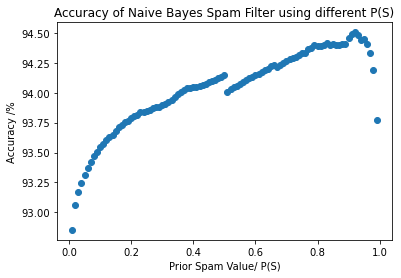

In [4]:
x = []
y = []
for key, value in prior_spam_dict.items():
    x.append(key)
    y.append(round(sum(value)/len(value),4))
max_acc = max(y)
highest_prior_index = y.index(max_acc)
highest_prior = x[highest_prior_index]
print("The highest average accuracy over 50 random tests for each p(S) is " + str(max_acc) + " with a p(S) of "+ str(highest_prior) + "!")
x = np.array(x)
y = np.array(y)
plt.scatter(x, y)
plt.xlabel("Prior Spam Value/ P(S)")
plt.ylabel("Accuracy /%")
plt.title("Accuracy of Naive Bayes Spam Filter using different P(S)")

plt.show()
